In [61]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.integrate import ode
from scipy import interpolate

import os
import time

In [2]:
Ipath = "/Users/alexanderjulianty/neurodyn/IforRealNeuron.csv"
Vpath = "/Users/alexanderjulianty/neurodyn/neurodyndata/V1.dat"

Idat = np.genfromtxt(Ipath, delimiter=',')
V1dat = np.fromfile(open(Vpath))

In [3]:
V_ref = 1 #V_ref is the bias on the chip. Grnd is now at 1V
I_master = 1.25e-9
I_voltage = 230e-9
I_ref = 85e-9
K = (0.018) * 1e-9 #scaling factor for injected current
C_m = 4e-12 #membrane potential
C_gate = 5e-12

shift = 0
time_len = 4000e-3 #time simulation is 4s
kappa = 0.7
Ut = 26e-3 #Jun's code calls this the "unit volt (26mv)"
Res = 1.63e6 #some kind of resistance

g0 = [800, 160, 15] #maximal conductances
e_rev = [300, -210, -190] #reversal potentials

g = np.multiply(g0,(kappa / Ut) * (I_master / 1024)) #scaling conductance values for chip
E_rev = np.multiply(e_rev,(I_voltage / 1024) * Res) + V_ref #scaling and shifting reversal potentials

vBias = np.zeros(7)
vHigh = V_ref + 1.85e6 * I_voltage
vLow = V_ref - 1.85e6 * I_voltage
I_factor = (vHigh - vLow) / 700e3
vBias[0] = vLow + I_factor * 50e3 

for i in np.arange(1,7):
    vBias[i] = vBias[i - 1] + I_factor * 100e3 #[0.6352, 0.7568, 0.8742, 1.000, 1.12157, 1.24314, 1.3647]
    
am = [0, 0, 120, 400, 800, 1023, 1023]
bm = [1023, 1023, 1023, 1023, 0, 0, 0]

#ah = [237, 5, 7, 6, 0, 0, 0] #Numbers from paper
ah = [237, 80, 0, 0, 0, 0, 0] #Jun's numbers
#bh = [0, 0, 0, 0, 41, 25, 8] #Numbers from paper
bh = [0, 0, 0, 0, 41, 50, 70] #Jun's numbers

#an = [0, 0, 0, 0, 18, 5, 43] #Numbers from paper
an = [0, 0, 0, 0, 18, 5, 43] #Jun's numbers
bn = [1, 0, 0, 1, 0, 0, 1]

In [4]:

def sigma(V_bk, V, sign = 1): #Why did we define sigma in this way?
    kappa = 0.7
    Ut = 26e-3
    return 1 / (1 + np.exp(sign * kappa * (V_bk - V) / Ut))

g_f = 1 / (C_gate * Ut)

def alpha(V, x):
    alpha = 0
    for k in np.arange(7):
        if x == "m":
            alpha += am[k] * sigma(vBias[k], V, 1)
        if x == "h":
            alpha += ah[k] * sigma(vBias[k], V, -1)
        if x == "n":
            alpha += an[k] * sigma(vBias[k], V, 1)
    return alpha * I_master / 1024 * g_f


def beta(V, x):
    beta = 0
    for k in np.arange(7):
        if x == "m":
            beta += bm[k] * sigma(vBias[k], V, -1)
        if x == "h":
            beta += bh[k] * sigma(vBias[k], V, 1)
        if x == "n":
            beta += bn[k] * sigma(vBias[k], V, -1)
    return beta * I_master / 1024 * g_f


Here we define our system as well as the injected current

In [53]:
fIdat = interpolate.interp1d(np.arange(0,len(Idat)), Idat) #Used to interpolate time points that are undefined in Idat

def I_inj(t):
    if t * 5e3 <= len(Idat):
#        return Idat[int(np.round(t * 5e3, 0))] * K
        return fIdat(t * 5e3) * K
    else:
        return 0

def neuron(y, t):
    v, m, h, n = y
    # g = (2.62e-8, 5.25e-9, 4.9e-10)
    # E_rev = (1.109, 0.923, 0.9304)
    I_na = g[0] * m**3 * h * (v - E_rev[0])
    I_k = g[1] * n**4 * (v - E_rev[1])
    I_l = g[2] * (v - E_rev[2])
    
    dvdt = (I_inj(t) - I_na - I_l - I_k) / C_m
    dmdt = alpha(v, "m") * (1 - m) - beta(v, "m") * m
    dhdt = alpha(v, "h") * (1 - h) - beta(v, "h") * h
    dndt = alpha(v, "n") * (1 - n) - beta(v, "n") * n
    
    dydt = [dvdt, dmdt, dhdt, dndt]

    return dydt



We set the initial conditions and time window

In [60]:
y0 = [1.09, 0.5, 0.5, 0.5] #initial conditions
t_step = 1e-3
t_max = 4
t = np.linspace(0, t_max, int(t_max / t_step + 1))

start_time = time.time()
sol = odeint(neuron, y0, t, args=())
print "Time elapsed:", time.time() - start_time

Plot the data

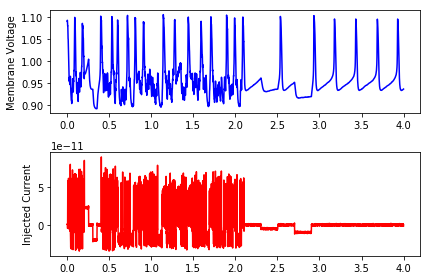

In [62]:
twindow = t[tmin:tmax]
plt.subplot(2,1,1)
plt.plot(t, sol[:,0], 'b')
plt.ylabel('Membrane Voltage')

plt.subplot(2,1,2)
plt.plot(t, fIdat(t * 5e3) * K, 'r')
plt.ylabel('Injected Current')

plt.tight_layout()
plt.show()

Save data

In [111]:
data = np.append(t,sol).reshape(len(t),5)
data = np.append(data, fIdat(t * 5e3))
data = data.reshape(len(t),6)
np.save('ode_data.npy', data)

# Attempting to use the 4th order Runge Kutta Method in scipy.integrate.ode

## Sanity Check

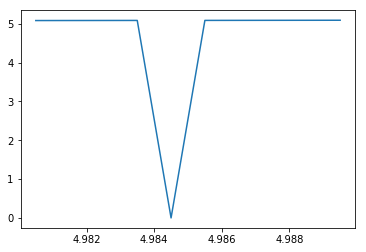

In [67]:
y0 = 0.1
t0 = 0
dt = 0.001
t1 = 10

def func(t, y): # derivative of x^2
    return 1
r = ode(func).set_integrator('dopri5')
r.set_initial_value(y0,t0)

solution = np.zeros(10000)
while r.successful() and r.t < t1:
    r.integrate(r.t + dt)
    solution[int(r.t * 1000 - 1)] = r.y

t = np.linspace(0, 10, 10000)
plt.plot(t[4980:4990], solution[4980:4990])
#plt.plot(t, solution)
plt.show()

# Membrane Dynamics
$C_{mem} \frac{dV}{dt} = -I_{Na} - I_{K} - I_L + I_{inj}$

$I_{Na} = G_{Na}m^3h (V - E_{Na})$

$I_K = G_K n^4 (V- E_K)$

$I_L = G_L (V- E_L)$

Gating Variables

$\frac{dx}{dt} = \alpha_x(V) (1-x) - \beta_x(V) x$

$\alpha_x(V) = \Sigma_{k=1}^7 \alpha_{x,k}\sigma_k(V)$

$\beta_x(V) = \Sigma_{k=1}^7 \beta_{x,k}\sigma_k(V)$

$\sigma_k(V) = \frac{1}{1+e^{\pm \mu(V_{b,k}-V)}}$

Is the sigma form for alpha and beta unique to our implementation?

$V_{b,k} = V_{b,min} + \frac{k-1}{6}(V_{b,max}-V_{b,min})$